In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools
using Random

In [2]:
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [3]:
truth = (σy = 0.6, σang = 0.3, xw = 2)
n = 10^3

1000

In [4]:
data = (y0 = rand(Normal(0.0, truth.σy), n), ang = rand(Normal(0.0, truth.σang), n),);

In [5]:
pred(x, waist, y, ang) = y .+ ang .* (x-waist)

pred (generic function with 1 method)

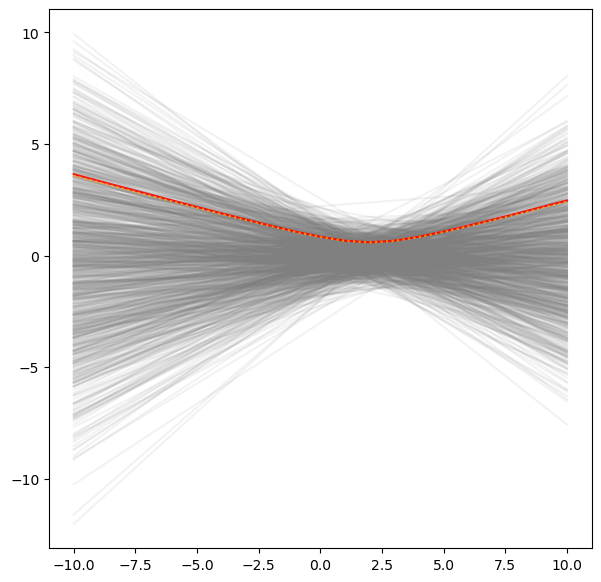

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8b839fcfd0>

In [6]:
x = -10:10
y = [pred(x_r, truth.xw, data.y0, data.ang) for x_r in x]
y_std = [std(y_tmp) for y_tmp in y]

truth_env = sqrt.(truth.σy^2 .+ truth.σang.^2 .* (x .- truth.xw).^2 )

fig, ax= plt.subplots(1,1, figsize=(7,7))

for i in 1:n
    y_run = [y_tmp[i] for y_tmp in y]
    ax.plot(x, y_run, color="gray", alpha=0.1)
end

ax.plot(x, truth_env, color="red", alpha=0.9)
ax.plot(x, y_std, color="orange", alpha=0.9, ls=":")


In [7]:
fit_data = (x = [x[i] for i in [1,7,14,20]], y = [fit(Histogram, y[i], nbins=20) for i in [1,7,14,20]]);

In [8]:
function log_lik(; data = fit_data)
    
    return params -> begin   
        
        ll = 0.0
        σ_vect = sqrt.(params.σy^2 .+ params.σang.^2 .* (data.x .- params.xw).^2 )
        
        for i in 1:4
            y_pred = params.I[i] * pdf.(Normal.(params.μ[i], σ_vect[i]), midpoints(data.y[i].edges[1]))
            ll += sum(logpdf.(Normal.(y_pred, params.fluct[i]), data.y[i].weights ))
        end
        
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik()

#47 (generic function with 1 method)

In [9]:
prior_ang = NamedTupleDist(
    μ = [-5 .. 5, -5 .. 5, -5 .. 5, -5 .. 5],
    fluct = [0 .. 10^3, 0 .. 10^3, 0 .. 10^3, 0 .. 10^3],
    I = [0 .. 10^4 for i in 1:4],
    σy = 0 .. 2,
    σang = 0 .. 2,
    xw = -5 .. 5,
);

In [10]:
par_tmp = rand(prior_ang)

(μ = [0.4028135066095455, -3.6005969599870857, 4.99751056484795, 4.37752514222295], fluct = [99.03730718821558, 899.9934075847362, 394.7491514366799, 60.0863859369527], I = [5403.627016360338, 7507.448525702614, 5993.110366699757, 7079.659035689885], σy = 0.5506626349666703, σang = 1.0899409399184092, xw = -0.9844857210113123)

In [11]:
log_likelihood(par_tmp)

LogDVal{Float64}(-545.0569018929416)

In [12]:
iter = 8000
iter_warmup = 500
chains = 4;

In [13]:
posterior = PosteriorDensity(log_likelihood, prior_ang);

In [14]:
posterior_is = bat_transform(PriorToGaussian(), posterior, PriorSubstitution()).result;

In [15]:
metric = BAT.DiagEuclideanMetric()
integrator = BAT.LeapfrogIntegrator()
proposal = BAT.NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = BAT.StanHMCAdaptor(0.8, iter_warmup)
hmc_sampler = HamiltonianMC(metric, ForwardDiff, integrator, proposal, adaptor);

In [16]:
@time samples_is = bat_sample(posterior_is, iter, MCMCSampling(sampler = hmc_sampler, nchains = chains));

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /user/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /user/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /user/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due t

 42.175850 seconds (110.55 M allocations: 23.002 GiB, 23.96% gc time)


In [50]:
samples = samples_is.result;

In [51]:
trafo_is = trafoof(posterior_is.likelihood)
samples = inv(trafo_is).(samples);

In [52]:
sz = size(flatview(unshaped.(samples.v)))

(15, 8000)

In [55]:
param_mode = mode(samples)

ShapedAsNT((μ = [0.17241710397576604, 0.029390911266816033, -0.0025628026900834655, -0.02542862764407161], fluct = [4.863256802110263, 4.184089683150371, 6.505774561390945, 1.9241841020790809], I = [1022.8377993546522, 1010.693954322133, 201.71187538902794, 1005.3468148781744], σy = 0.6121732786757867, σang = 0.30457736090229515, xw = 2.049688939983537))

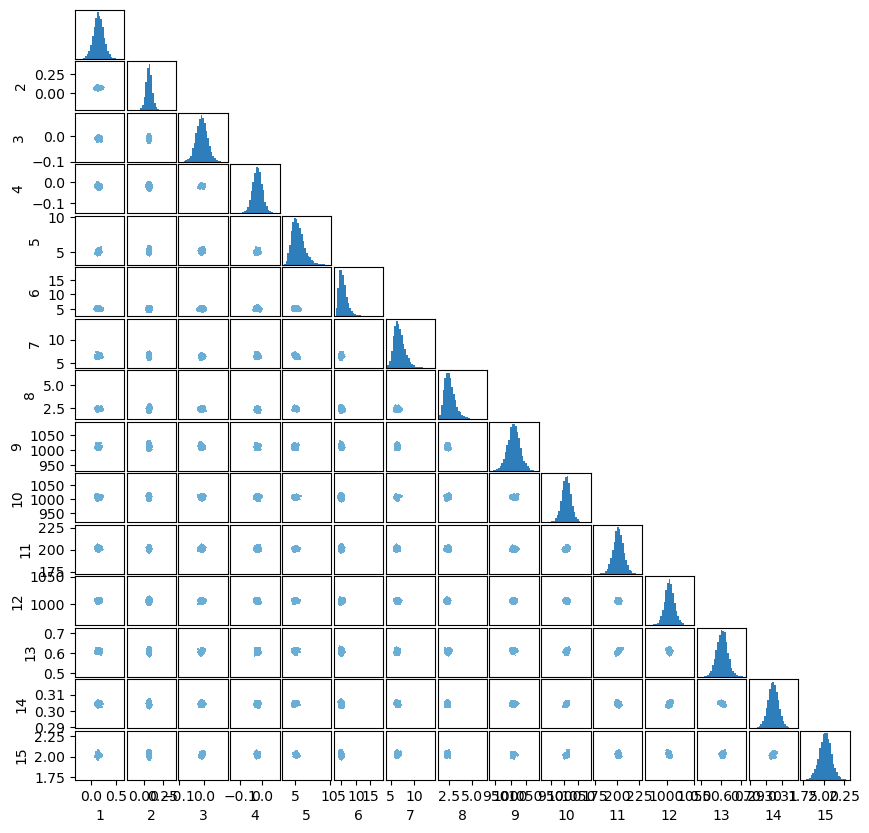

In [56]:
dims = 1:15
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 30

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)